In [0]:
!pip install torch

In [0]:
!apt-get install graphviz -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import pandas as pd
from time import time
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import LabelEncoder
import os
from torchvision import models, transforms, datasets
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from sklearn.metrics import accuracy_score
from torchsummary import summary
from torch.utils.data import DataLoader, sampler
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from timeit import default_timer as timer


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!unzip -uq "/content/drive/My Drive/car_images_no_int_BMW_Audi 2.zip" -d "/content/imagine"

In [0]:
#path configuration
#parent_dir = '/content/drive/My Drive/thecarconnectionpicturedataset2'

In [0]:
%cd '/content/drive/My Drive/thecarconnectionpicturedataset2'

/content/drive/My Drive/thecarconnectionpicturedataset2


In [0]:
%pwd 

'/content/drive/My Drive/thecarconnectionpicturedataset2'

In [0]:
# Location of data
dataset='thecarconnectionpicturedataset2'
datadir = '/content/drive/My Drive/thecarconnectionpicturedataset2/'
traindir = datadir + 'trainpca'
validdir = datadir + 'valid'
testdir = datadir + 'test'

In [0]:
image_transforms={
    'train':
    transforms.Compose([
        transforms.Resize(size=256),          
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  #removed color jogger because we've already preprocessed pictures by PCA
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    
    ]),
    'test' :
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [0]:
data={
    'train':
    datasets.ImageFolder(root=traindir,transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir,transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir,transform=image_transforms['test'])
}

dataloaders= {
    'train': DataLoader(data['train'],shuffle=True,batch_size=128),
    'val' : DataLoader(data['val'],shuffle=True,batch_size=128),
    'test' : DataLoader(data['test'],shuffle=True,batch_size=128)
}

In [0]:
train_data_size = len(data['train'])
valid_data_size = len(data['val'])
test_data_size = len(data['test'])


train_data_loader = dataloaders['train']
valid_data_loader = dataloaders['val']
test_data_loader = dataloaders['test']

# New Section

In [0]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [0]:
# loading the pretrained model
model_1 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
# Freeze model weights
for parameter in model_1.parameters():
    parameter.requires_grad = False

In [0]:
# Add on classifier
model_1.classifier[6] = nn.Sequential(
    nn.Linear(4096, 256), nn.ReLU(),
    nn.Linear(256, 2),nn.LogSoftmax(dim=1))

for parameter in model_1.classifier[6].parameters():
    parameter.requires_grad = True

In [0]:
model_1.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=2, bias=True)
    (3): LogSoftmax()
  )
)

In [0]:
# checking if GPU is available if yes, then running on gpu
if torch.cuda.is_available():
    model_1 = model_1.cuda()

In [0]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
loss_criterion = nn.NLLLoss()

# specify optimizer (stochastic gradient descent) and learning rate
# gradient descent on the layer that we customized in transfer learning
optimizer = optim.Adam(model_2.classifier.parameters())

In [0]:
def train_and_validate(model, loss_criterion, optimizer, epochs=20):
  start = time.time
  history=[]
  best_acc=0.0
  

  for epoch in range(epochs):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, epochs))

    model.train()

    train_loss=0.0
    train_acc=0.0
    valid_loss=0.0
    valid_acc=0.0
    for i,(inputs,labels) in enumerate(train_data_loader):
      inputs=inputs.cuda()
      labels=labels.cuda()
      optimizer.zero_grad()
      outputs=model(inputs)
      loss=loss_criterion(outputs,labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * inputs.size(0)
      ret, predictions = torch.max(outputs.data, 1)
      correct_counts = predictions.eq(labels.data.view_as(predictions))
      acc = torch.mean(correct_counts.type(torch.FloatTensor))
      train_acc += acc.item() * inputs.size(0)
    with torch.no_grad():
      model.eval()
      for j, (inputs, labels) in enumerate(valid_data_loader):
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        loss = loss_criterion(outputs, labels)
        valid_loss += loss.item() * inputs.size(0)
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        valid_acc += acc.item() * inputs.size(0)
    avg_train_loss = train_loss/train_data_size
    avg_train_acc = train_acc/train_data_size
    avg_valid_loss = valid_loss/valid_data_size 
    avg_valid_acc = valid_acc/valid_data_size
    history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
    epoch_end = time.time()
    print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
    torch.save(model, dataset+'_alexnetwithpca_'+str(epoch)+'.pt')
    
    

  return model, history

In [0]:
import time
trained_model, history = train_and_validate(model_1, loss_criterion, optimizer, epochs=20)

Epoch: 1/20
Epoch : 000, Training: Loss: 0.6780, Accuracy: 59.3987%, 
		Validation : Loss : 0.6221, Accuracy: 67.4242%, Time: 2157.1618s
Epoch: 2/20
Epoch : 001, Training: Loss: 0.5987, Accuracy: 67.7071%, 
		Validation : Loss : 0.5547, Accuracy: 74.5868%, Time: 63.8297s
Epoch: 3/20
Epoch : 002, Training: Loss: 0.5425, Accuracy: 71.5630%, 
		Validation : Loss : 0.5437, Accuracy: 71.7631%, Time: 62.9287s
Epoch: 4/20
Epoch : 003, Training: Loss: 0.5236, Accuracy: 73.1696%, 
		Validation : Loss : 0.4847, Accuracy: 79.4077%, Time: 62.9013s
Epoch: 5/20
Epoch : 004, Training: Loss: 0.5025, Accuracy: 74.5467%, 
		Validation : Loss : 0.4704, Accuracy: 79.7521%, Time: 63.1145s
Epoch: 6/20
Epoch : 005, Training: Loss: 0.4820, Accuracy: 76.0156%, 
		Validation : Loss : 0.4500, Accuracy: 79.4077%, Time: 63.2791s
Epoch: 7/20
Epoch : 006, Training: Loss: 0.4690, Accuracy: 76.8878%, 
		Validation : Loss : 0.4302, Accuracy: 83.0579%, Time: 63.4825s
Epoch: 8/20
Epoch : 007, Training: Loss: 0.4419, Accu

In [0]:
torch.save(history, dataset+'_vggpcahistory.pt')

Text(0.5, 0, 'Epoch Number')

Text(0, 0.5, 'Loss')

(0, 1)

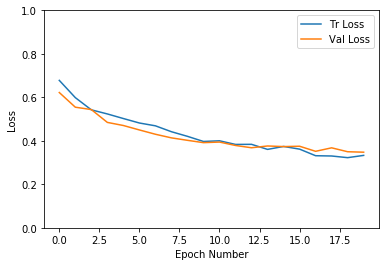

In [0]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

Text(0.5, 0, 'Epoch Number')

Text(0, 0.5, 'Accuracy')

(0, 1)

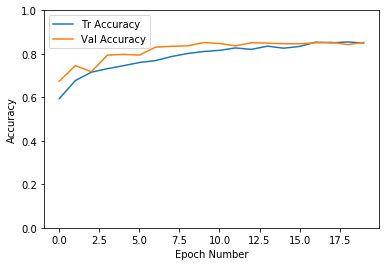

In [0]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [0]:
def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))

In [0]:
bestvggpca = torch.load('thecarconnectionpicturedataset2_modelwithpca_17.pt')

In [0]:
computeTestSetAccuracy(bestvggpca, loss_criterion)

Test Batch number: 000, Test: Loss: 0.4068, Accuracy: 0.8359
Test Batch number: 001, Test: Loss: 0.4288, Accuracy: 0.7812
Test Batch number: 002, Test: Loss: 0.4050, Accuracy: 0.8281
Test Batch number: 003, Test: Loss: 0.3795, Accuracy: 0.8281
Test Batch number: 004, Test: Loss: 0.2557, Accuracy: 0.9219
Test Batch number: 005, Test: Loss: 0.5088, Accuracy: 0.8516
Test Batch number: 006, Test: Loss: 0.4391, Accuracy: 0.8125
Test Batch number: 007, Test: Loss: 0.3262, Accuracy: 0.8828
Test Batch number: 008, Test: Loss: 0.4138, Accuracy: 0.8438
Test Batch number: 009, Test: Loss: 0.4018, Accuracy: 0.7734
Test Batch number: 010, Test: Loss: 0.4011, Accuracy: 0.8281
Test Batch number: 011, Test: Loss: 0.3752, Accuracy: 0.7500
Test accuracy : 0.8326446280991735


In [0]:
model_2 = torch.hub.load('pytorch/vision:v0.5.0', 'alexnet', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.5.0.zip" to /root/.cache/torch/hub/v0.5.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


In [0]:
# Freeze model weights
for param in model_2.parameters():
    param.requires_grad = False

In [0]:
# Add on classifier
model_2.classifier[6] = nn.Sequential(
    nn.Linear(4096, 256), nn.ReLU(),
    nn.Linear(256, 2),nn.LogSoftmax(dim=1))
for param in model_2.classifier[6].parameters():
    param.requires_grad = True

In [0]:
# checking if GPU is available if yes, then running on gpu
if torch.cuda.is_available():
    model_2 = model_2.cuda()

In [0]:
import time
trained_model_pca_alex, history_pca_alex = train_and_validate(model_2, loss_criterion, optimizer, epochs=20)

Epoch: 1/20
Epoch : 000, Training: Loss: 0.6749, Accuracy: 62.9332%, 
		Validation : Loss : 0.5739, Accuracy: 70.8678%, Time: 2159.0633s
Epoch: 2/20
Epoch : 001, Training: Loss: 0.5306, Accuracy: 72.5499%, 
		Validation : Loss : 0.5031, Accuracy: 74.9311%, Time: 34.1084s
Epoch: 3/20
Epoch : 002, Training: Loss: 0.4720, Accuracy: 77.1632%, 
		Validation : Loss : 0.4752, Accuracy: 77.8237%, Time: 34.3142s
Epoch: 4/20
Epoch : 003, Training: Loss: 0.4388, Accuracy: 78.1272%, 
		Validation : Loss : 0.4541, Accuracy: 78.5124%, Time: 34.1258s
Epoch: 5/20
Epoch : 004, Training: Loss: 0.4088, Accuracy: 81.2256%, 
		Validation : Loss : 0.4215, Accuracy: 82.0937%, Time: 34.9482s
Epoch: 6/20
Epoch : 005, Training: Loss: 0.3576, Accuracy: 83.4060%, 
		Validation : Loss : 0.4161, Accuracy: 82.5758%, Time: 34.8132s
Epoch: 7/20
Epoch : 006, Training: Loss: 0.3351, Accuracy: 84.5077%, 
		Validation : Loss : 0.4283, Accuracy: 82.0937%, Time: 34.1092s
Epoch: 8/20
Epoch : 007, Training: Loss: 0.3057, Accu

In [0]:
torch.save(history_pca_alex, dataset+'_ALEXpcahistory.pt')

Text(0.5, 0, 'Epoch Number')

Text(0, 0.5, 'Loss')

(0, 1)

Text(0.5, 1.0, 'Loss Comparison for AlexNet with PCA')

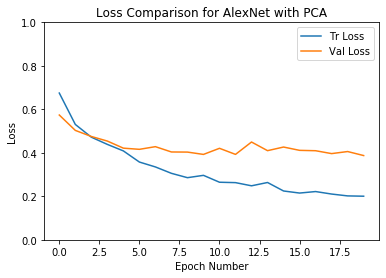

In [0]:
history_pca_alex = np.array(history_pca_alex)
plt.plot(history_pca_alex[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.title('Loss Comparison for AlexNet with PCA')
plt.savefig(dataset+'_loss_curve.png')
plt.show()

Text(0.5, 0, 'Epoch Number')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'Accuracy Comparison for AlexNet with PCA')

(0, 1)

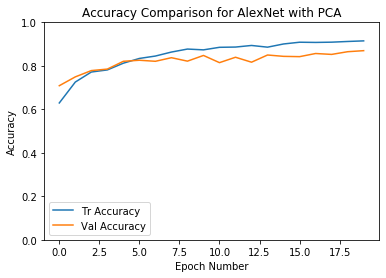

In [0]:
plt.plot(history_pca_alex[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison for AlexNet with PCA')
plt.ylim(0,1)
plt.savefig(dataset+'_alexpca_accuracy_curve.png')
plt.show()

In [0]:
bestalexpca = torch.load('thecarconnectionpicturedataset2_alexnetwithpca_5.pt')

In [0]:
computeTestSetAccuracy(bestalexpca, loss_criterion)

Test Batch number: 000, Test: Loss: 0.4082, Accuracy: 0.8516
Test Batch number: 001, Test: Loss: 0.3395, Accuracy: 0.8516
Test Batch number: 002, Test: Loss: 0.4139, Accuracy: 0.8203
Test Batch number: 003, Test: Loss: 0.3966, Accuracy: 0.8516
Test Batch number: 004, Test: Loss: 0.4634, Accuracy: 0.7891
Test Batch number: 005, Test: Loss: 0.4097, Accuracy: 0.8125
Test Batch number: 006, Test: Loss: 0.3949, Accuracy: 0.8125
Test Batch number: 007, Test: Loss: 0.4355, Accuracy: 0.7891
Test Batch number: 008, Test: Loss: 0.4416, Accuracy: 0.8281
Test Batch number: 009, Test: Loss: 0.2968, Accuracy: 0.8984
Test Batch number: 010, Test: Loss: 0.5357, Accuracy: 0.7656
Test Batch number: 011, Test: Loss: 0.4118, Accuracy: 0.8636
Test accuracy : 0.825757576085976
